In [1]:
%%capture
!pip install fastai==1.0.61

## Class for knowledge distillation

In [3]:
from fastai.basics import *

class KnowledgeDistillation(LearnerCallback):
    def __init__(self, learn:Learner, teacher:Learner, T:float=20., α:float=0.7):
        super().__init__(learn)
        self.teacher = teacher
        self.T, self.α = T, α
    
    def on_backward_begin(self, last_input, last_output, last_target, **kwargs):
        self.teacher.model.eval()
        teacher_output = self.teacher.model(last_input)
        new_loss = DistillationLoss(last_output, last_target, teacher_output, self.T, self.α)
        
        return {'last_loss': new_loss}

def DistillationLoss(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y/T, dim=-1), F.softmax(teacher_scores/T, dim=-1)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setting workspace

In [5]:
import boto3
import os
import cv2
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai.vision import *
from tqdm import tqdm

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "ClassificationModel",
    image_dir = "fastai_data",
    data_dir = "dataset_224",
    tar_file_name = "dataset.tar.gz",
    model_dir = "model",
    tar_model_name = "model.tar.gz"
)
s3 = boto3.resource('s3')
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))

## Resize data

In [16]:
imgpc = [os.path.join(data_path,l) for l in labels]
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
interpolation=cv2.INTER_LINEAR

new_data_path = os.path.join(args.root,args.new_data_dir)

for label in labels:
    img_cls = os.listdir(os.path.join(data_path,label))
    for im in tqdm(img_cls):
        #print(os.path.join(data_path,label,im))
        img = cv2.imread(os.path.join(data_path,label,im))
        path = os.path.join(new_data_path,label)
        try:
            img = cv2.resize(img, IMAGE_SIZE, interpolation=interpolation)
            if not os.path.exists(path):
                os.makedirs(path)
            
            cv2.imwrite(os.path.join(path,im),img)
        except:
            pass

## Upload data to S3

In [3]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    return output_filename

In [4]:
args.output_filename = make_tarfile(os.path.join(args.root, args.data_dir, args.tar_file_name), os.path.join(args.root, args.data_dir))

s3.meta.client.upload_file(args.output_filename, Bucket=args.bucket_name, Key=os.path.join(args.key,args.data_dir,args.tar_file_name))
os.remove(args.output_filename)

## Loading data

In [7]:
data = ImageDataBunch.from_folder(data_path, valid_pct=0.3, bs=32, ds_tfms=get_transforms(), size=224, num_workers=4, no_check=True).normalize(imagenet_stats)

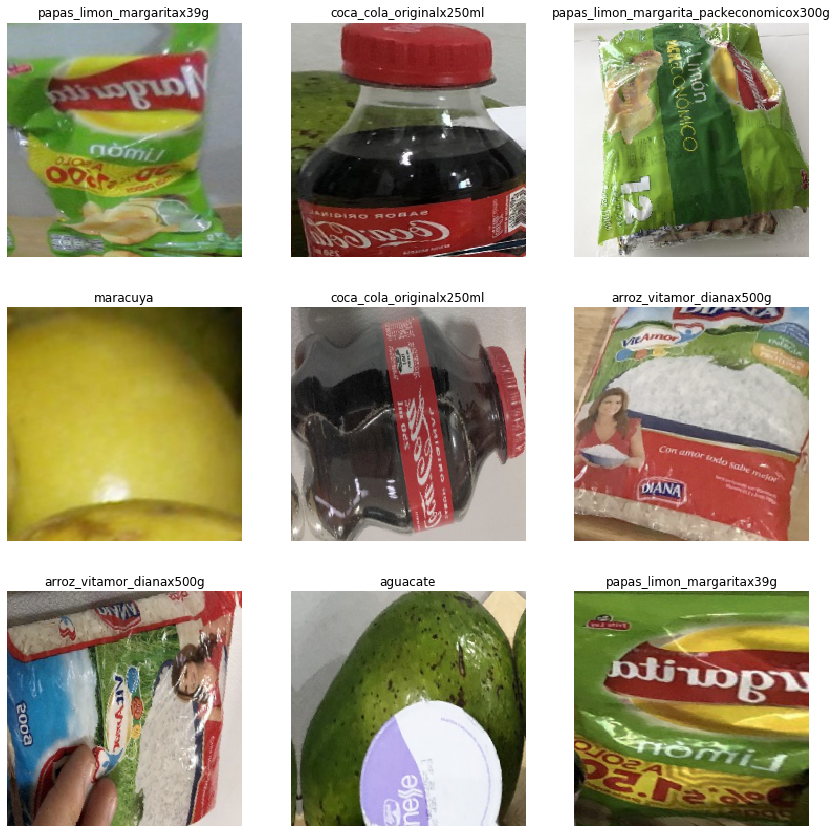

In [12]:
data.show_batch(rows=3)

## Training pretrained model

In [9]:
t_learner = cnn_learner(data, models.resnet18, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


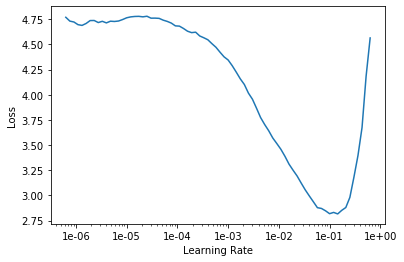

In [10]:
t_learner.lr_find()
t_learner.recorder.plot()

In [11]:
t_learner.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.565426,0.369318,0.130576,0.869424,01:07
1,0.584931,0.480836,0.139238,0.860762,01:02
2,0.527304,0.348399,0.118666,0.881334,01:03
3,0.392341,0.314283,0.113252,0.886748,01:02
4,0.350729,0.277062,0.096795,0.903205,01:03
5,0.299400,0.227886,0.083586,0.916414,01:04
6,0.225814,0.196110,0.068428,0.931572,01:03
7,0.211989,0.161863,0.057601,0.942399,01:03
8,0.170595,0.153946,0.054136,0.945864,01:03
9,0.170239,0.154397,0.053053,0.946947,01:02


In [12]:
t_learner.save(os.path.join(model_path,'resnet18'))

In [13]:
t_learner.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


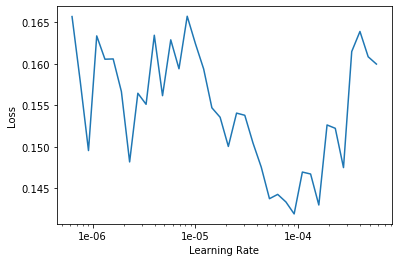

In [14]:
t_learner.lr_find()
t_learner.recorder.plot()

In [15]:
t_learner.fit_one_cycle(30,5e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.156031,0.150588,0.050238,0.949762,01:21
1,0.151191,0.150965,0.052620,0.947380,01:22
2,0.139280,0.147600,0.048722,0.951278,01:23
3,0.150084,0.145525,0.049589,0.950411,01:22
4,0.138079,0.146794,0.049589,0.950411,01:22
5,0.128976,0.145522,0.046557,0.953443,01:23
6,0.140642,0.156164,0.053919,0.946081,01:23
7,0.139190,0.152415,0.050888,0.949112,01:22
8,0.144000,0.167946,0.052837,0.947163,01:23
9,0.135879,0.154681,0.044825,0.955175,01:23


In [11]:
t_learner.export(os.path.join(model_path,'resnet18.pkl'))

In [16]:
t_learner.save(os.path.join(model_path,'resnet18_2'))

In [8]:
t_learner.load(os.path.join(model_path,'resnet18_2'))

Learner(data=ImageDataBunch;

Train: LabelList (10788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset_224;

Valid: LabelList (4623 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pan_de_queso_la_frontera,coca_cola_originalx250ml,maracuya,yogurt_alpina_finesse_fresax180g,coca_cola_originalx400ml
Path: /home/ec2-user/SageMaker/classification_model/dataset_224;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel

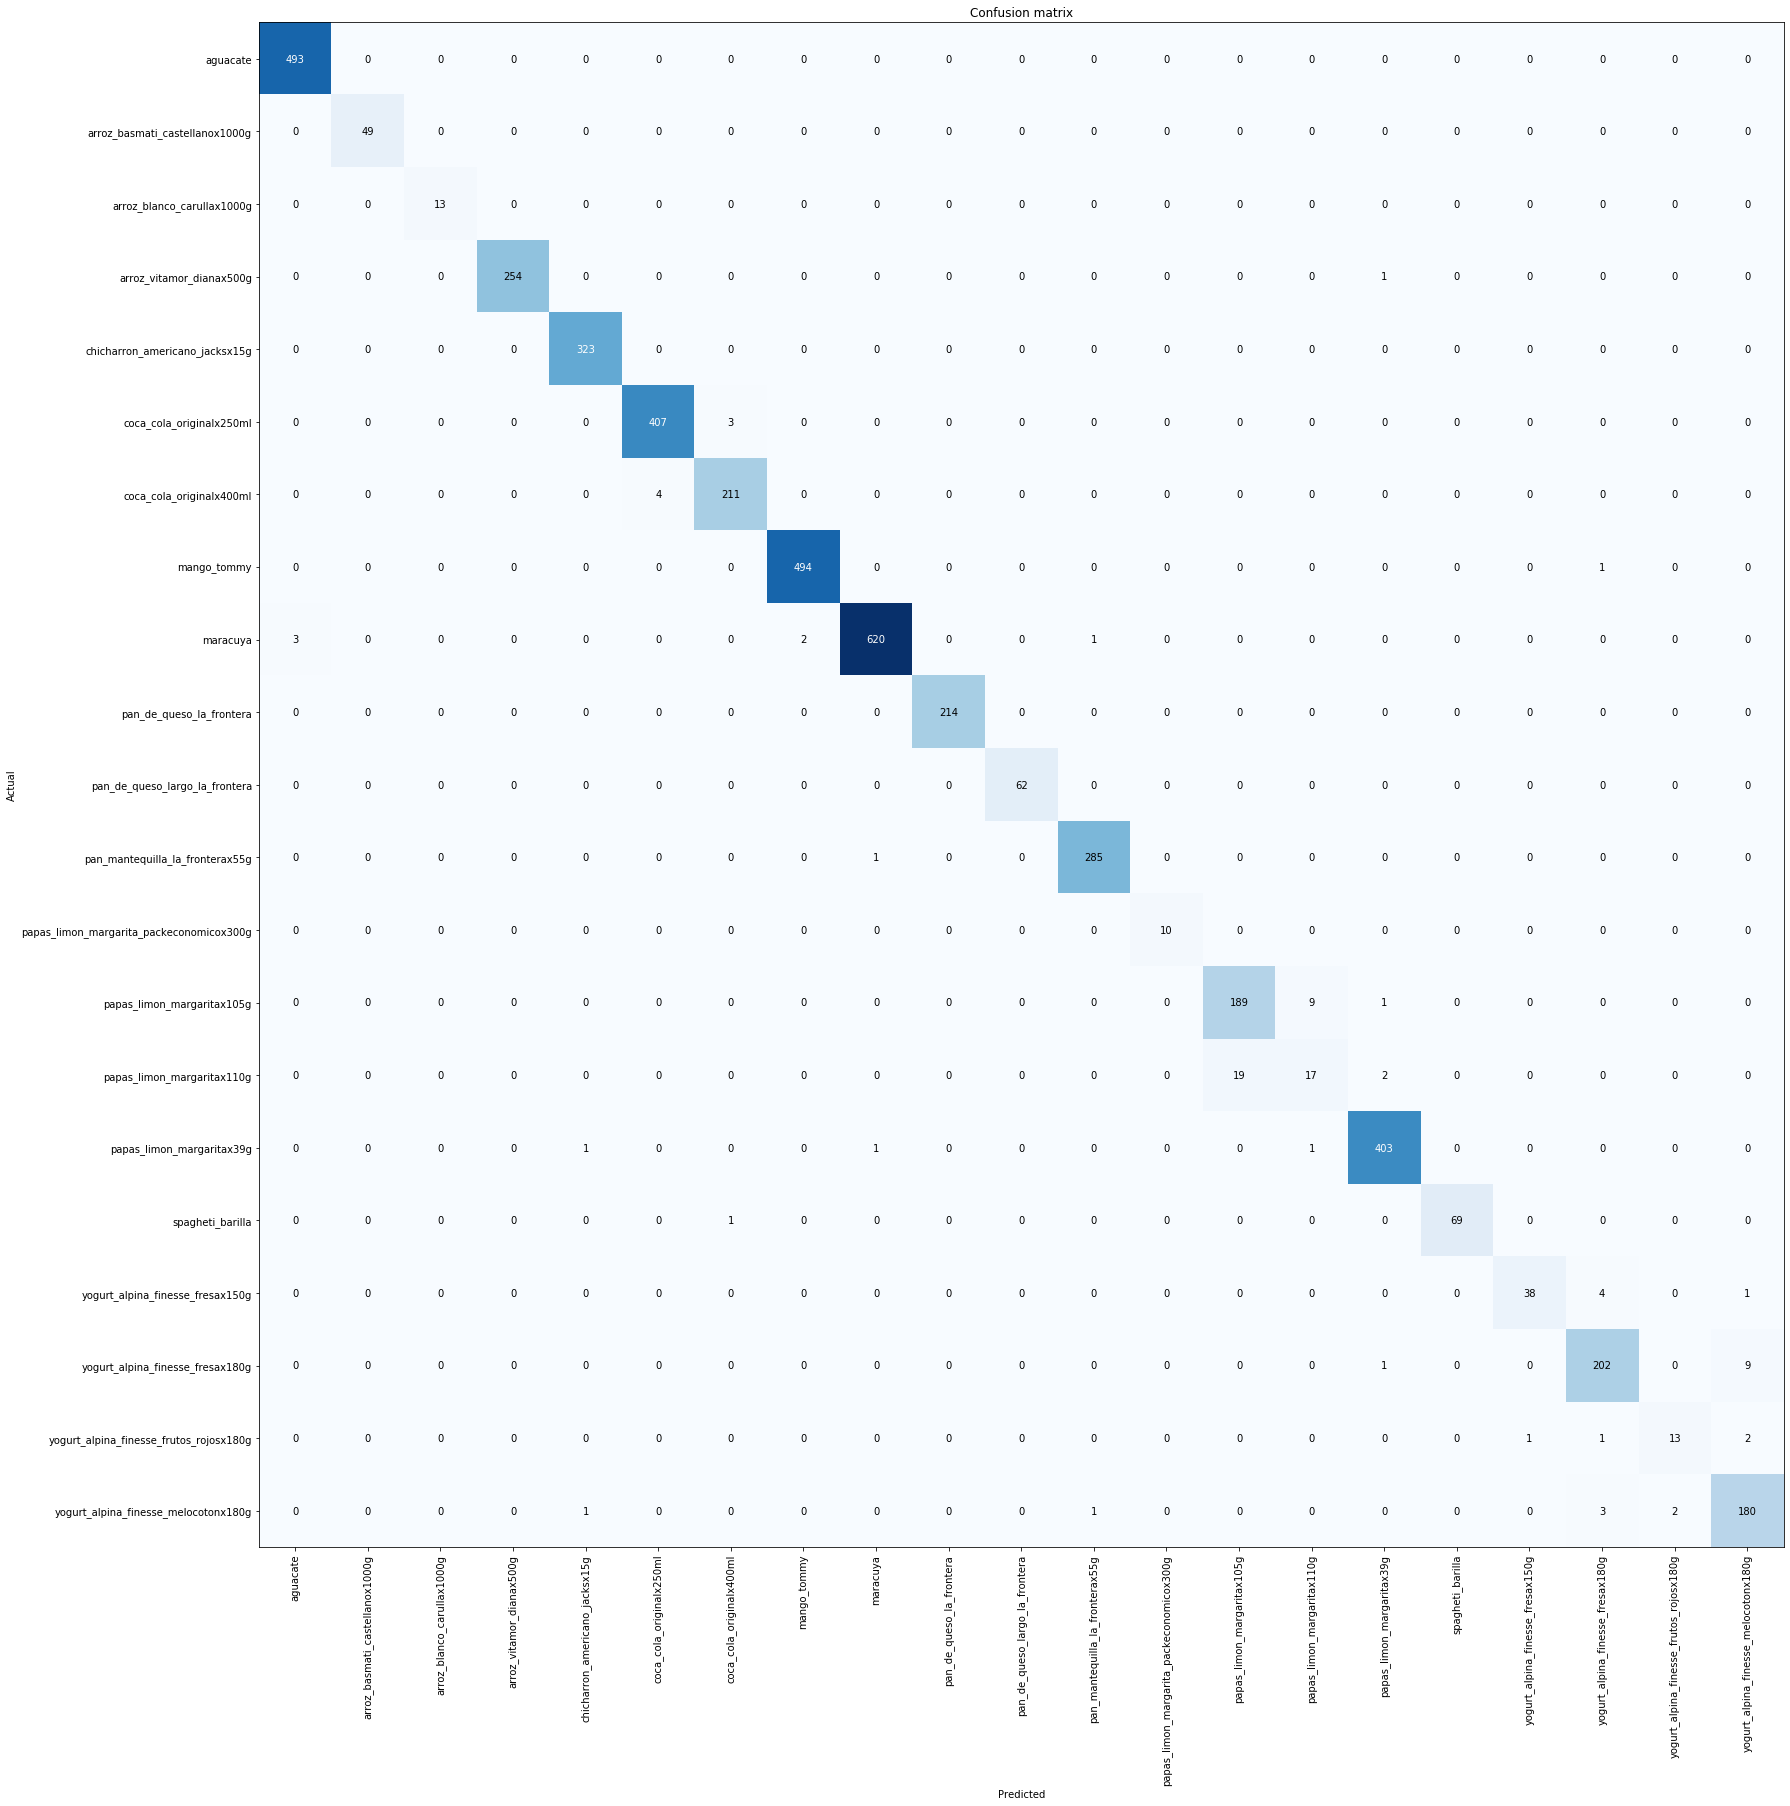

In [9]:
interp = ClassificationInterpretation.from_learner(t_learner)
interp.plot_confusion_matrix(figsize=(30,25))

## Prediction

pan_mantequilla_la_fronterax55g 0.9980117082595825
{
   "probabilities": {
      "aguacate": 1.647352831923854e-07,
      "arroz_basmati_castellanox1000g": 1.0917638974206056e-05,
      "arroz_blanco_carullax1000g": 2.5416914013476344e-06,
      "arroz_vitamor_dianax500g": 0.00013082184887025505,
      "chicharron_americano_jacksx15g": 6.185461188579211e-06,
      "coca_cola_originalx250ml": 6.472337645391235e-06,
      "coca_cola_originalx400ml": 3.4128297556890175e-06,
      "mango_tommy": 2.204289330620668e-06,
      "maracuya": 0.0014194443356245756,
      "pan_de_queso_la_frontera": 1.6554100511712022e-05,
      "pan_de_queso_largo_la_frontera": 0.00015882730076555163,
      "pan_mantequilla_la_fronterax55g": 0.9980117082595825,
      "papas_limon_margarita_packeconomicox300g": 2.1492469386430457e-06,
      "papas_limon_margaritax105g": 6.940130333532579e-06,
      "papas_limon_margaritax110g": 4.790037201019004e-05,
      "papas_limon_margaritax39g": 7.960621587699279e-05,
      

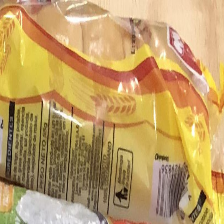

In [27]:
import json
from PIL import Image
#!curl "https://www.merkadomi.com/wp-content/uploads/2018/07/COCA-COLA-ORIGINAL-400ML.jpg" --output test.jpg
img_path = 'test12.jpg'
img = open_image(img_path)
pred_class,pred_idx,outputs = t_learner.predict(img.resize((3,224,224)))
print(pred_class, outputs[pred_idx].item())
print(json.dumps({"probabilities": {class_name: prob.item() 
                         for class_name, prob in zip(t_learner.data.classes, outputs)}}, indent=3))

#!rm test.jpg
#plt.imshow(np.transpose(unnormalize(t_learner.data.one_item(img.resize(224))[0].squeeze()).cpu(), (1, 2, 0)))
img

## Upload model to S3

In [23]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    return output_filename

In [24]:
args.output_filename = make_tarfile(os.path.join(args.root, args.model_dir, args.tar_model_name), 
                                             os.path.join(args.root, args.model_dir))
s3.meta.client.upload_file(args.output_filename, Bucket=args.bucket_name, Key=os.path.join(args.key,
                                                                                         args.model_dir,
                                                                                         args.tar_model_name))
os.remove(args.output_filename)